# Simple AutoML for time series with Ray AIR

AutoML (Automatic Machine Learning) boils down to picking the best model for a given task and dataset. In {doc}`this Ray Core example </ray-core/examples/automl_for_time_series>`, we showed how to build an AutoML system which will chooses the best `statsforecast` model and its corresponding hyperparameters for a time series regression task on the [M5 dataset](https://www.kaggle.com/c/m5-forecasting-accuracy).

The basic steps were:

1. Define a set of autoregressive forecasting models to search over. For each model type, we also define a set of model parameters to search over.
2. Perform temporal cross-validation on each model configuration in parallel.
3. Pick the best performing model as the output of the AutoML system.

We see that these steps fit into the framework of a hyperparameter optimization problem that can be tackled with the [Ray AIR Tuner](air-tuner)!

In this notebook, we will show how to:
1. **Create an AutoML system with Ray AIR** for time series forecasting.
2. Leverage the higher-level Tuner API to **define the model and hyperparameter search space**, as well as **parallelize cross-validation** of different models.
3. Analyze results to **identify the best-performing model type and model parameters** for the time-series dataset.

Similar to {doc}`the Ray Core example </ray-core/examples/automl_for_time_series>`, we will be using only one partition of the [M5 dataset](https://www.kaggle.com/c/m5-forecasting-accuracy) for this example.

## Setup

Let's first start by installing the `statsforecast` and `ray[air]` packages.

In [ ]:
!pip install statsforecast
!pip install ray[air]

Next, we'll make the necessary imports, then initialize and connect to our Ray cluster!

In [2]:
import time
import itertools
import pandas as pd
import numpy as np
from collections import defaultdict
from statsforecast import StatsForecast
from statsforecast.models import ETS, AutoARIMA, _TS
from pyarrow import parquet as pq
from sklearn.metrics import mean_squared_error, mean_absolute_error

import ray
from ray import air, tune

In [ ]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env={"pip": ["statsforecast"]})

```{note}
We may want to run on multiple nodes, and setting the `runtime_env` to include the `statsforecast` module will guarantee that we can access it on each worker, regardless of which node it lives on.
```

## Read a partition of the M5 dataset from S3

We first obtain the data from an S3 bucket and preprocess it to the format that `statsforecast` expects. As the dataset is quite large, we use PyArrow’s push-down predicate as a filter to obtain just the rows we care about without having to load them all into memory.

In [4]:
def get_m5_partition(unique_id: str) -> pd.DataFrame:
    ds1 = pq.read_table(
        "s3://anonymous@m5-benchmarks/data/train/target.parquet",
        filters=[("item_id", "=", unique_id)],
    )
    Y_df = ds1.to_pandas()
    # StatsForecasts expects specific column names!
    Y_df = Y_df.rename(
        columns={"item_id": "unique_id", "timestamp": "ds", "demand": "y"}
    )
    Y_df["unique_id"] = Y_df["unique_id"].astype(str)
    Y_df["ds"] = pd.to_datetime(Y_df["ds"])
    Y_df = Y_df.dropna()
    constant = 10
    Y_df["y"] += constant
    Y_df = Y_df[Y_df.unique_id == unique_id]
    return Y_df

train_df = get_m5_partition("FOODS_1_001_CA_1")
train_df

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,13.0
1,FOODS_1_001_CA_1,2011-01-30,10.0
2,FOODS_1_001_CA_1,2011-01-31,10.0
3,FOODS_1_001_CA_1,2011-02-01,11.0
4,FOODS_1_001_CA_1,2011-02-02,14.0
...,...,...,...
1936,FOODS_1_001_CA_1,2016-05-18,10.0
1937,FOODS_1_001_CA_1,2016-05-19,11.0
1938,FOODS_1_001_CA_1,2016-05-20,10.0
1939,FOODS_1_001_CA_1,2016-05-21,10.0


## Create a function that performs cross-validation

Next, we will define two methods below:
1. `cross_validation` **performs temporal cross-validation** on the dataset and **reports the mean prediction error across cross-validation splits**. See the [visualizations in the analysis section below](automl-temporal-cross-validation-splits) to see what the cross-validation splits look like and what we are averaging across. The `n_splits` and `test_size` parameters are used to configure the cross-validation splits, similar to [`TimeSeriesSplit` from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).
2. `compute_metrics_and_aggregate` is a helper function used in `cross_validation` that calculates the aggregated metrics using the dataframe output of `StatsForecast.cross_validation`. For example, we will calculate the mean squared error between the model predictions and the actual observed data, averaged over all training splits. This metric gets reported to Tune as `mse_mean`, which is the metric we will use to define the best-performing model.

We will run this cross-validation function on all the model types and model parameters we are searching over, and the model that produces the lowest error metric will be the output of this AutoML example. Notice that `model_cls_and_params` is passed to the function via the `config` parameter. This is how Tune will set the corresponding model class and parameters for each trial.

In [5]:
from ray.air import Checkpoint, session

def cross_validation(config, Y_train_df=None):
    assert Y_train_df is not None, "Must pass in the dataset"

    # Get the model class
    model_cls, model_params = config.get("model_cls_and_params")
    freq = config.get("freq")
    metrics = config.get("metrics", {"mse": mean_squared_error})

    # CV params
    test_size = config.get("test_size", None)
    n_splits = config.get("n_splits", 5)

    model = model_cls(**model_params)

    # Default the parallelism to the # of cross-validation splits
    parallelism_kwargs = {"n_jobs": n_splits}

    # Initialize statsforecast with the model
    statsforecast = StatsForecast(
        df=Y_train_df,
        models=[model],
        freq=freq,
        **parallelism_kwargs,
    )

    # Perform temporal cross-validation (see `sklearn.TimeSeriesSplit`)
    test_size = test_size or len(Y_train_df) // (n_splits + 1)

    start_time = time.time()
    forecasts_cv = statsforecast.cross_validation(
        h=test_size,
        n_windows=n_splits,
        step_size=test_size,
    )
    cv_time = time.time() - start_time

    # Compute metrics (according to `metrics`)
    cv_results = compute_metrics_and_aggregate(forecasts_cv, model, metrics)

    # Report metrics and save cross-validation output DataFrame
    results = {
        **cv_results,
        "cv_time": cv_time,
    }
    checkpoint_dict = {
        "cross_validation_df": forecasts_cv,
    }
    checkpoint = Checkpoint.from_dict(checkpoint_dict)
    session.report(results, checkpoint=checkpoint)

In [ ]:
def compute_metrics_and_aggregate(
    forecasts_df: pd.DataFrame, model: _TS, metrics: dict
):
    unique_ids = forecasts_df.index.unique()
    assert len(unique_ids) == 1, "This example only expects a single time series."

    cutoff_values = forecasts_df["cutoff"].unique()

    # Calculate metrics of the predictions of the models fit on
    # each training split
    cv_metrics = defaultdict(list)
    for ct in cutoff_values:
        # Get CV metrics for a specific training split
        # All forecasts made with the same `cutoff` date
        split_df = forecasts_df[forecasts_df["cutoff"] == ct]
        for metric_name, metric_fn in metrics.items():
            cv_metrics[metric_name].append(
                metric_fn(
                    split_df["y"], split_df[model.__class__.__name__]
                )
            )

    # Calculate aggregated metrics (mean, std) across training splits
    cv_aggregates = {}
    for metric_name, metric_vals in cv_metrics.items():
        try:
            cv_aggregates[f"{metric_name}_mean"] = np.nanmean(
                metric_vals
            )
            cv_aggregates[f"{metric_name}_std"] = np.nanstd(
                metric_vals
            )
        except Exception as e:
            cv_aggregates[f"{metric_name}_mean"] = np.nan
            cv_aggregates[f"{metric_name}_std"] = np.nan

    return {
        "unique_ids": list(unique_ids),
        **cv_aggregates,
        "cutoff_values": cutoff_values,
    }

## Define the model search space

We want to search over the following set of models and their corresponding parameters:

In [7]:
search_space = {
    AutoARIMA: {},
    ETS: {
        "season_length": [6, 7],
        "model": ["ZNA", "ZZZ"],
    }
}

This translates to 5 possible `(model_class, model_params)` configurations, which we
generate using the helper function below.

In [8]:
def generate_configurations(search_space):
    for model, params in search_space.items():
        if not params:
            yield model, {}
        else:
            configurations = itertools.product(*params.values())
            for config in configurations:
                config_dict = {k: v for k, v in zip(params.keys(), config)}
                yield model, config_dict

configs = list(generate_configurations(search_space))
configs

[(statsforecast.models.AutoARIMA, {}),
 (statsforecast.models.ETS, {'season_length': 6, 'model': 'ZNA'}),
 (statsforecast.models.ETS, {'season_length': 6, 'model': 'ZZZ'}),
 (statsforecast.models.ETS, {'season_length': 7, 'model': 'ZNA'}),
 (statsforecast.models.ETS, {'season_length': 7, 'model': 'ZZZ'})]

## Create a Tuner to run a grid search over configurations

Now that we have defined the search space as well as the cross-validation function to apply to each configuration inside that search space, we can define our Ray AIR Tuner to launch the trials in parallel.

Here's a summary of what we are doing in the code below:

- First, we include the training dataset using {meth}`tune.with_parameters <ray.tune.with_parameters>`, which will put the dataset into the Ray object storage so that it can be retrieved as a common reference from every Tune trial.
- Next, we define the Tuner `param_space`. We use Tune's {meth}`tune.grid_search <ray.tune.grid_search>` to create one trial for each `(model_class, model_params)` tuple that we want to try. The rest of the parameters are constants that will be passed into the `config` parameter along with `model_cls_and_params`.
- Finally, we specify that we want to *minimize* the reported `mse_mean` metric.

We can launch the trials by using {meth}`Tuner.fit <ray.tune.tuner.Tuner.fit>`, which returns a {class}`ResultGrid <ray.tune.result_grid.ResultGrid>` that we can use for analysis.

In [ ]:
tuner = tune.Tuner(
    tune.with_parameters(cross_validation, Y_train_df=train_df),
    param_space={
        "model_cls_and_params": tune.grid_search(configs),
        "n_splits": 5,
        "test_size": 1,
        "freq": "D",
        "metrics":  {"mse": mean_squared_error, "mae": mean_absolute_error},
    },
    tune_config=tune.TuneConfig(
        metric="mse_mean",
        mode="min",
    ),
)

result_grid = tuner.fit()

Great, we've computed cross-validation metrics for all the models! Let's get the result of this AutoML system by selecting the best-performing trial using {meth}`ResultGrid.get_best_result <ray.tune.result_grid.ResultGrid.get_best_result>`!

In [10]:
best_result = result_grid.get_best_result()

We can take a look at the hyperparameter config of the best result:

In [11]:
best_result.config

{'model_cls_and_params': (statsforecast.models.ETS,
  {'season_length': 6, 'model': 'ZNA'}),
 'n_splits': 5,
 'test_size': 1,
 'freq': 'D',
 'metrics': {'mse': <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
  'mae': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>}}

Within this config, we can pull out the model type and parameters that resulted in the lowest forecast error!

In [12]:
best_model_cls, best_model_params = best_result.config["model_cls_and_params"]
print("Best model type:", best_model_cls)
print("Best model params:", best_model_params)

Best model type: <class 'statsforecast.models.ETS'>
Best model params: {'season_length': 6, 'model': 'ZNA'}


We can also inspect the reported metrics:

In [13]:
print("Best mse_mean:", best_result.metrics["mse_mean"])
print("Best mae_mean:", best_result.metrics["mae_mean"])

Best mse_mean: 0.64205205
Best mae_mean: 0.7200615


## Analysis

Finally, let's wrap up this AutoML example by performing some basic analysis and plotting.

(automl-temporal-cross-validation-splits)=
### Visualize Temporal Cross-validation Splits

Let's first take a look at how cross-validation is being performed. This plot shows how our parameters of `n_splits=5` and `test_size=1` are being used to generate the cross-validation splits. Only the last 50 points in the dataset are shown for visualization purposes.

For each of the 5 splits, the blue ticks represent the data used to train the model. The orange tick is the index that the model is tying to predict, and it's just a single point due to setting `test_size=1`. The metrics are calculated by comparing the predicted value to the actual data at the orange data point. The grey points represent data that is not considered for the split.

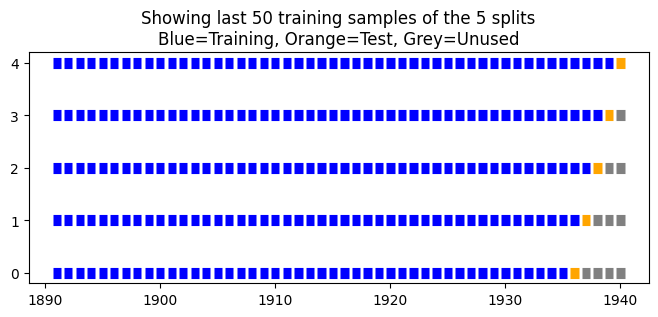

In [14]:
cutoff_values_for_cv = best_result.metrics["cutoff_values"]
test_size = best_result.config.get("test_size")
mse_per_split = best_result.metrics["mse_mean"]
cutoff_idxs = [np.where(train_df["ds"] == ct)[0][0] for ct in cutoff_values_for_cv]
colors = np.array(["blue", "orange", "grey"])

import matplotlib.pyplot as plt

show_last_n = 50

plt.figure(figsize=(8, 3))
for i, cutoff_idx in enumerate(cutoff_idxs):
    dataset_idxs = np.arange(len(train_df))[-show_last_n:]
    color_idxs = np.zeros_like(dataset_idxs)
    color_idxs[dataset_idxs > cutoff_idx] = 1
    color_idxs[dataset_idxs > cutoff_idx + test_size] = 2
    plt.scatter(
        x=dataset_idxs,
        y=np.ones_like(dataset_idxs) * i,
        c=colors[color_idxs],
        marker="_",
        lw=8
    )

plt.title(
    f"Showing last {show_last_n} training samples of the {len(cutoff_idxs)} splits\n"
    "Blue=Training, Orange=Test, Grey=Unused"
)
plt.show()

### Visualize model forecasts

Earlier, we saved the cross-validation output DataFrame inside a Ray AIR {class}`Checkpoint <ray.air.checkpoint.Checkpoint>`. We can use this to visualize some predictions of the best model! The predictions are pulled from the cross-validation results, where each step is predicted with `horizon=1`.

Again, we only show the last 50 timesteps for visualization purposes.

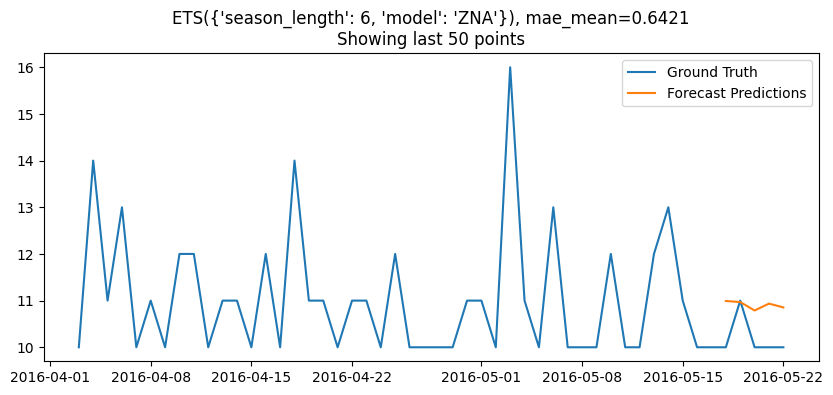

In [15]:
def plot_model_predictions(result, train_df):
    model_cls, model_params = result.config["model_cls_and_params"]
    
    # Get the predictions from the data stored within this result's checkpoint
    checkpoint_dict = result.checkpoint.to_dict()
    forecast_df = checkpoint_dict["cross_validation_df"]
    
    # Only show the last 50 timesteps of the ground truth data
    max_points_to_show = 50
    plt.figure(figsize=(10, 4))
    plt.plot(
        train_df["ds"][-max_points_to_show:],
        train_df["y"][-max_points_to_show:],
        label="Ground Truth"
    )
    plt.plot(
        forecast_df["ds"],
        forecast_df[model_cls.__name__],
        label="Forecast Predictions"
    )
    plt.title(
        f"{model_cls.__name__}({model_params}), "
        f"mae_mean={result.metrics['mse_mean']:.4f}\n"
        f"Showing last {max_points_to_show} points"
    )
    plt.legend()

    plt.show()

plot_model_predictions(best_result, train_df)

We can also visualize the predictions of the other models.

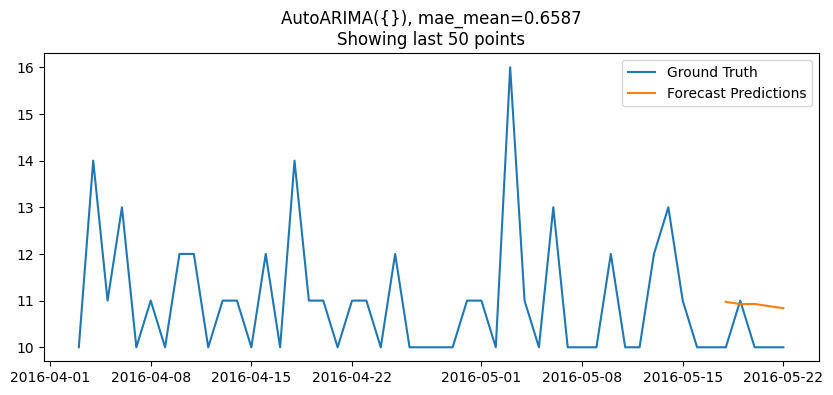

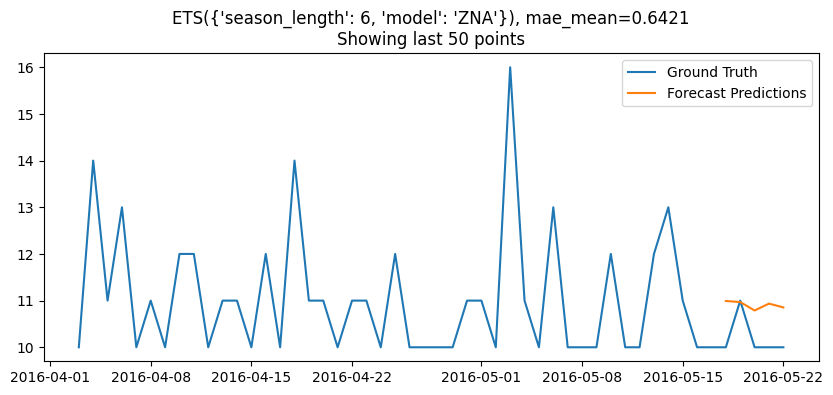

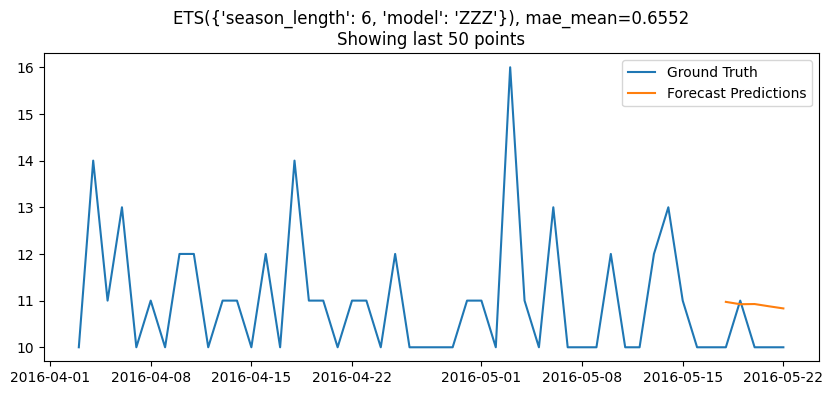

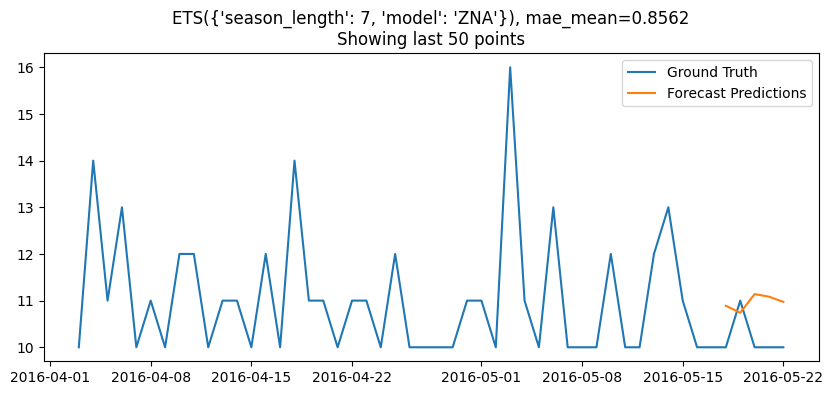

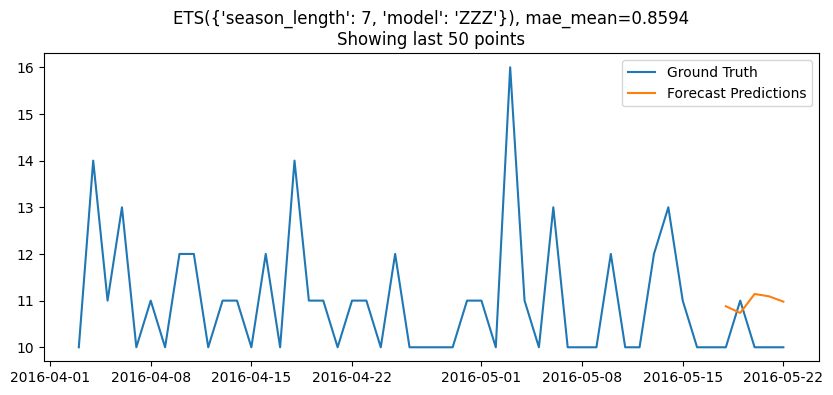

In [16]:
# Plot for all results
for result in result_grid:
    plot_model_predictions(result, train_df)